In [ ]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## ANOMALY DETECTION PART 3 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs




In [1]:
#=================================================-
#### Slide 26: Loading packages  ####

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest




In [ ]:
#=================================================-
#### Slide 27: Directory settings  ####

# Set 'main_dir' to location of the project folder
from pathlib import Path 
data_dir = Path.cwd().parent / "data"




In [52]:
#=================================================-
#### Slide 28: Load the dataset  ####

from pathlib import Path 
data_dir = Path.cwd().parent / "data"
paysim = pd.read_csv(data_dir / "paysim_transactions.csv")
paysim.head()




,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,308,CASH_OUT,94270.99,C473084216,0.0,0.0,C1130422007,392411.08,486682.07,0,0
1,215,TRANSFER,1068883.00,C116497934,227.3,0.0,C321541184,4096905.34,5165788.35,0,0
2,326,TRANSFER,2485281.21,C2089305953,54940.0,0.0,C1473680645,177829.59,2663110.80,0,0
3,371,PAYMENT,2243.36,C1200351076,0.0,0.0,M1583169191,0.00,0.00,0,0
4,283,PAYMENT,5845.82,C1501258365,0.0,0.0,M1431167213,0.00,0.00,0,0


In [53]:
#=================================================-
#### Slide 29: Prepare the dataset for modeling  ####

# Drop columns. 
paysim = paysim.drop(['step', 'type','nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
paysim.columns




Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')

In [220]:
#================================================= -
#### Slide 30: LOF on fraud dataset  ####

train, test = train_test_split(paysim, test_size=.30, random_state=42)

# Split fraud vs non fraud.
non_fraud = train[train['isFraud'] == 0] 
fraud = train[train['isFraud'] == 1]
non_fraud = non_fraud.drop('isFraud', axis=1)
test = pd.concat([test, fraud])

In [221]:
actual_test = test['isFraud']

In [68]:
#=================================================-
#### Slide 31: Create and fit LOF model  ####

lof = LocalOutlierFactor(n_neighbors=5, 
                         metric="manhattan", 
                         contamination=0.1, 
                         novelty=True)

# model fitting
lof.fit(non_fraud)

LocalOutlierFactor(contamination=0.1, metric='manhattan', n_neighbors=5,
                   novelty=True)

In [69]:
test

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
11167,23835.87,69763.00,45927.13,0.00,0.00,0
3912,32952.37,88354.00,55401.63,0.00,0.00,0
12717,81393.52,195216.00,113822.48,0.00,81393.52,0
11660,5357.80,0.00,0.00,0.00,0.00,0
4153,165418.39,5628940.42,5794358.81,370554.64,303236.08,0
...,...,...,...,...,...,...
11312,601494.61,601494.61,0.00,0.00,0.00,1
4642,186375.38,186375.38,0.00,0.00,0.00,1
8050,2451423.58,2451423.58,0.00,0.00,0.00,1
9339,918087.96,918087.96,0.00,0.00,0.00,1


In [70]:
#=================================================-
#### Slide 32: Test predictions  ####

fraud_pred = lof.predict(test.iloc[:,:-1])
fraud_pred = pd.Series(fraud_pred).map({1: 0, -1: 1})
fraud_pred

/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


0       0
1       0
2       0
3       1
4       0
       ..
6217    1
6218    0
6219    1
6220    1
6221    0
Length: 6222, dtype: int64

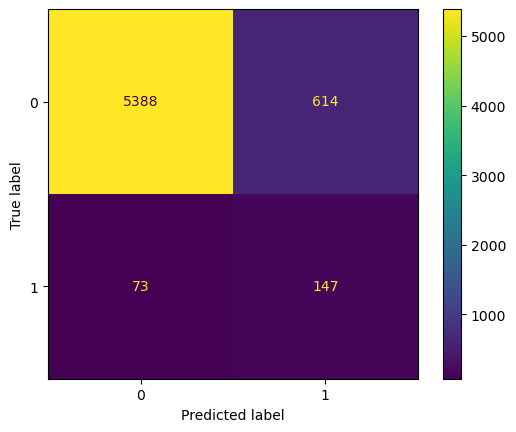

In [71]:
cmd = metrics.ConfusionMatrixDisplay.from_predictions(actual_test, fraud_pred);
(tn, fp), (fn, tp) = cmd.confusion_matrix

In [72]:
#================================================= -
#### Slide 33: Find TPR and TNR  ####

non_fraud_eval = tn / (tn + fp)
print("tnr:", non_fraud_eval)
fraud_eval = tp / (tp + fn)
print("tpr:",fraud_eval)




tnr: 0.8977007664111962
tpr: 0.6681818181818182


In [73]:
print(metrics.classification_report(actual_test, fraud_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      6002
           1       0.19      0.67      0.30       220

    accuracy                           0.89      6222
   macro avg       0.59      0.78      0.62      6222
weighted avg       0.96      0.89      0.92      6222



In [ ]:
#=================================================-
#### Slide 34: Exercise 1  ####






In [251]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
import seaborn as sns

In [255]:
gscv = GridSearchCV(
    LocalOutlierFactor(metric = "manhattan", novelty = True),
    {"n_neighbors": range(101, 201), "contamination": np.arange(.001, .01, .001)},
    scoring=metrics.make_scorer(metrics.recall_score),
)

y_test = test["isFraud"].map({0: 1, 1: -1})

X_test = test.drop("isFraud", axis=1)

In [256]:
gscv.fit(X_test, y_test)

/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fit

GridSearchCV(estimator=LocalOutlierFactor(metric='manhattan', novelty=True),
             param_grid={'contamination': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'n_neighbors': range(51, 101)},
             scoring=make_scorer(recall_score))

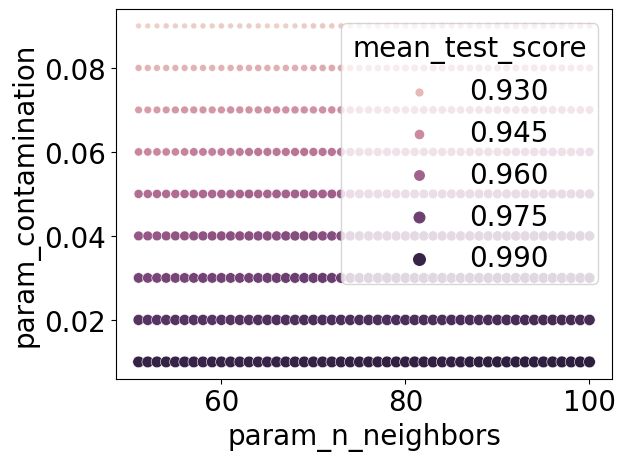

In [257]:
cv_df = pd.DataFrame(gscv.cv_results_)

sns.scatterplot(
    data=cv_df,
    x="param_n_neighbors",
    y="param_contamination",
    size="mean_test_score",
    hue="mean_test_score",
);

In [258]:
gscv.best_estimator_

LocalOutlierFactor(contamination=0.01, metric='manhattan', n_neighbors=100,
                   novelty=True)

In [259]:
gscv.best_score_

0.9931753154636317

In [204]:
scorer = metrics.make_scorer(score)

In [210]:
metrics.recall_score(y_true=actual_test, y_pred=fraud_pred)

0.35

In [215]:
score(y_true=actual_test, y_pred=fraud_pred)

0


0.0

In [219]:
actual_test.unique()

array([-1])

In [226]:
actual_test

11167    1
3912     1
12717    1
11660    1
4153     1
        ..
11312   -1
4642    -1
8050    -1
9339    -1
7629    -1
Name: isFraud, Length: 6222, dtype: int64

In [218]:
actual_test[actual_test == 0] = 1
actual_test[actual_test == 1] = -1

In [214]:
def score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(tp)
    return tp / (tp + fn)

In [102]:
lof_df = pd.DataFrame()
for neighbor in range(2, 91):
    lof = LocalOutlierFactor(n_neighbors = neighbor, metric = "manhattan", novelty = True)
    lof.fit(non_fraud)
    fraud_pred = lof.predict(test.iloc[:,:-1])
    fraud_pred[fraud_pred == 1] = 0
    fraud_pred[fraud_pred == -1] = 1
    tn, fp, fn, tp = confusion_matrix(actual_test, fraud_pred).ravel()
    non_fraud_eval = tn / (tn + fp)
    fraud_eval = tp / (tp + fn)
    values = [neighbor,non_fraud_eval,fraud_eval]
    values = pd.DataFrame(values).T
    lof_df = pd.concat([lof_df,values])
    

/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fit

In [103]:
lof_df

,0,1,2
0,2.0,0.824059,0.704545
0,3.0,0.873376,0.654545
0,4.0,0.895035,0.659091
0,5.0,0.905531,0.645455
0,6.0,0.912862,0.677273
...,...,...,...
0,86.0,0.869377,0.804545
0,87.0,0.868710,0.813636
0,88.0,0.867711,0.813636
0,89.0,0.867711,0.813636


In [104]:
lof_df.columns=['Neighbor','TNR','TPR']

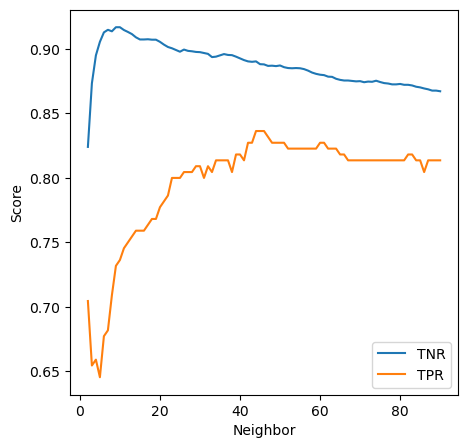

In [105]:
plt.figure(figsize=(5,5))
plt.plot(lof_df['Neighbor'],lof_df['TNR'], label
= 'TNR')
plt.plot(lof_df['Neighbor'],lof_df['TPR'], label
= 'TPR')
plt.xlabel('Neighbor')
plt.ylabel('Score')
plt.legend(loc="lower right")

In [85]:
contamination_values = [0.01,0.03,0.05,0.1,0.2,0.3,0.4,0.5]
lof_df = pd.DataFrame()
for contamination_value in contamination_values:
    lof = LocalOutlierFactor(n_neighbors = 20, metric = "manhattan",contamination =
    contamination_value, novelty = True)
    lof.fit(non_fraud)
    fraud_pred = lof.predict(test.iloc[:,:-1])
    fraud_pred[fraud_pred == 1] = 0
    fraud_pred[fraud_pred == -1] = 1
    tn, fp, fn, tp = confusion_matrix(actual_test, fraud_pred).ravel()
    non_fraud_eval = tn / (tn + fp)
    fraud_eval = tp / (tp + fn)
    values = [contamination_value,non_fraud_eval,fraud_eval]
    values = pd.DataFrame(values).T
    lof_df = pd.concat([lof_df,values])
lof_df.columns=['Contamination','TNR','TPR']

/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fit

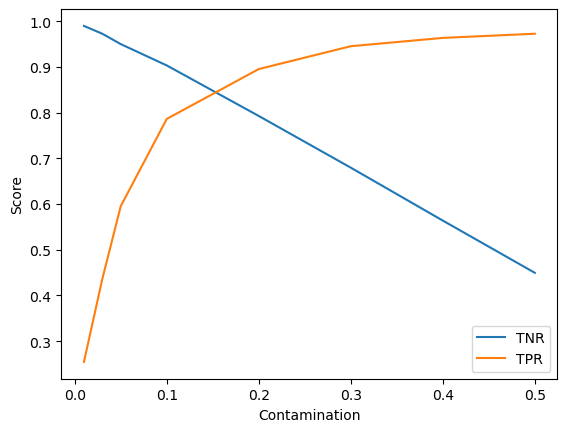

In [86]:
plt.plot(lof_df['Contamination'],lof_df['TNR'],
label = 'TNR')
plt.plot(lof_df['Contamination'],lof_df['TPR'],
label = 'TPR')
plt.xlabel('Contamination')
plt.ylabel('Score')
plt.legend(loc="lower right")

In [ ]:
#================================================= -
#### Slide 41: Optimized LOF model  ####

lof = LocalOutlierFactor(n_neighbors = 10, 
                         metric = "manhattan", 
                         contamination = 0.1, 
                         novelty = True)

# model fitting
lof.fit(non_fraud)




In [ ]:
#=================================================-
#### Slide 42: Test predictions  ####

fraud_pred = lof.predict(test.iloc[:,:-1])
fraud_pred[fraud_pred == 1] = 0
fraud_pred[fraud_pred == -1] = 1
tn, fp, fn, tp = confusion_matrix(actual_test, fraud_pred).ravel()
non_fraud_eval = tn / (tn + fp)
print(non_fraud_eval)
fraud_eval = tp / (tp + fn)
print(fraud_eval)




In [111]:
#=================================================-
#### Slide 43: Load performance_df dataframe  ####

performance_df = pickle.load(open(str(data_dir)+"/performance_anomalies.sav","rb"))  
s = pd.Series(['LOF', fraud_eval, non_fraud_eval], 
              index=['model_name', 'TPR', 'TNR'])
performance_df = performance_df.append(s, ignore_index = True)
performance_df




/var/folders/v9/w_9ybtvs4llcfyj_k3gstvnr0000gr/T/ipykernel_40380/3617906228.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_df = performance_df.append(s, ignore_index = True)


,model_name,TPR,TNR
0,Decision_tree_baseline,0.671642,0.999667
1,SMOTE,0.865672,0.991332
2,LOF,0.772727,0.890927
3,LOF,0.759091,0.903280
4,LOF,0.750000,0.894868
5,LOF,0.745455,0.900367
6,LOF,0.754545,0.892982
7,LOF,0.722727,0.893376
8,LOF,0.813636,0.867211


In [ ]:
#=================================================-
#### Slide 45: Exercise 2  ####






In [119]:
non_fraud.to_pickle(data_dir / "non_fraud.pkl")
test.to_pickle(data_dir / "test.pkl")
actual_test.to_pickle(data_dir / "actual_test.pkl")
performance_df.to_pickle(data_dir / "performance_anomalies.pkl")

In [ ]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## ANOMALY DETECTION PART 4 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs




In [120]:
#=================================================-
#### Slide 2: Loading packages  ####

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest




In [121]:
non_fraud = pd.read_pickle(data_dir / "non_fraud.pkl")
test = pd.read_pickle(data_dir / "test.pkl")
actual_test = pd.read_pickle(data_dir / "actual_test.pkl")
performance_df = pd.read_pickle(data_dir / "performance_anomalies.pkl")

In [ ]:
pjm

In [123]:
#=================================================-
#### Slide 5: Data: load energy consumption  ####

pjm_energy = pd.read_csv(data_dir / "PJME_hourly.csv", parse_dates=["Datetime"])
pjm_energy.head()




,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [124]:
#=================================================-
#### Slide 6: Data: preprocessing  ####

pjm_energy.info()
pjm_energy = pjm_energy[pjm_energy['Datetime'] > '2018-01-01 00:00:00']
pjm_energy.shape




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


(5135, 2)

In [125]:
#=================================================-
#### Slide 9: Create and fit LOF model: energy consumption  ####

lof_energy_model = LocalOutlierFactor(n_neighbors = 50, 
                                      metric = "manhattan", 
                                      contamination = 0.01, 
                                      novelty = False)
                                      
pjm_energy['anomaly'] = lof_energy_model.fit_predict(pd.DataFrame(pjm_energy['PJME_MW']))




In [126]:
#=================================================-
#### Slide 11: LOF - visualize anomalies  ####

lower_threshold = pjm_energy['PJME_MW'].quantile(0.25)
upper_threshold = pjm_energy['PJME_MW'].quantile(0.75)
lof_anomalies = pjm_energy[pjm_energy['anomaly'] == -1]
# Upper range of anomalies
lof_upper_anomalies = lof_anomalies[lof_anomalies['PJME_MW'] > upper_threshold]['PJME_MW']

# Lower range of anomalies
lof_lower_anomalies = lof_anomalies[lof_anomalies['PJME_MW'] < lower_threshold]['PJME_MW']




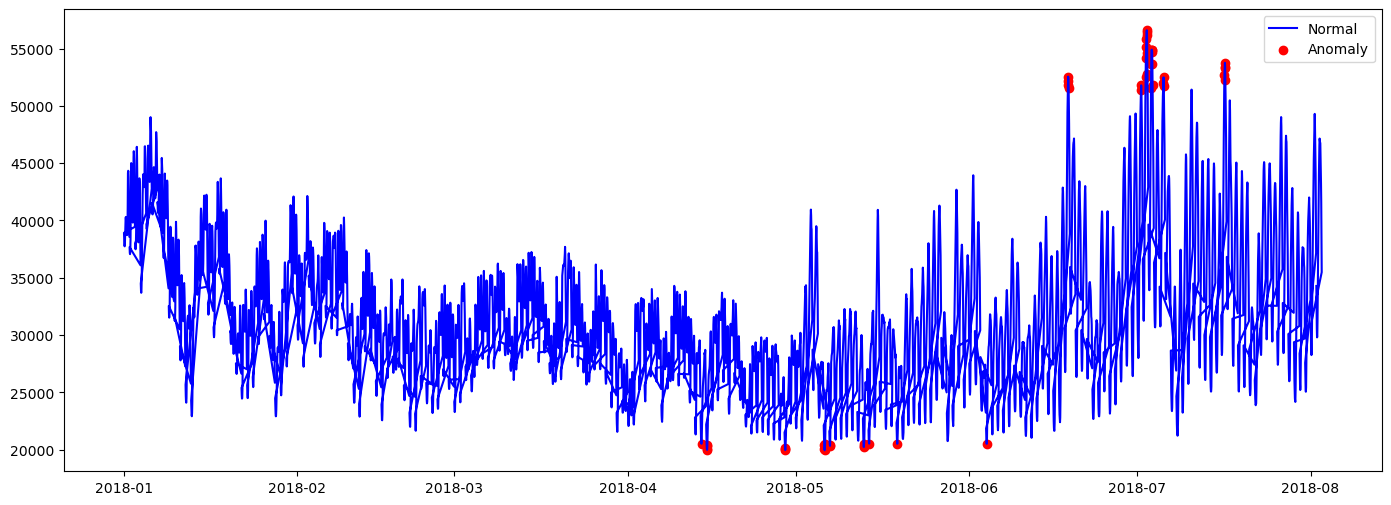

In [128]:
fig, ax = plt.subplots(figsize=(17,6))
a = pjm_energy.loc[pjm_energy['anomaly'] == -1, ['Datetime', 'PJME_MW']] #anomaly
ax.plot(pjm_energy['Datetime'], pjm_energy['PJME_MW'], color='blue', label = 'Normal')
ax.scatter(a['Datetime'],a['PJME_MW'], color='red', label = 'Anomaly')
plt.legend();

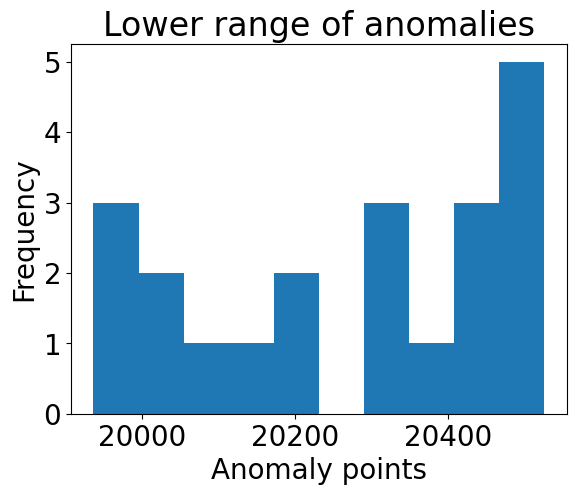

In [132]:
plt.rcParams.update({'font.size': 20})
plt.hist(lof_lower_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Lower range of anomalies");

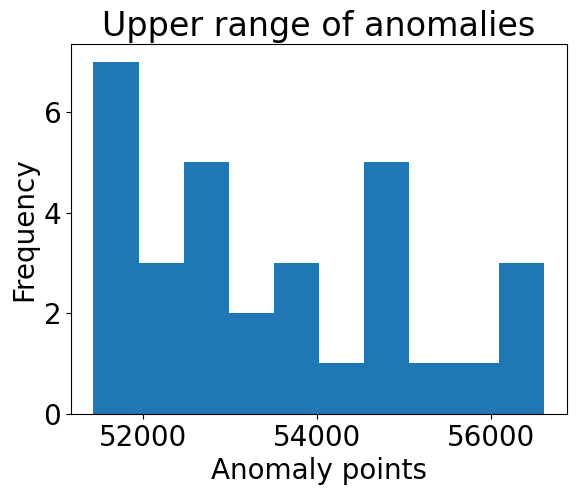

In [134]:
plt.hist(lof_upper_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Upper range of anomalies");

In [ ]:
#=================================================-
#### Slide 13: Exercise 3  ####






In [137]:
non_fraud.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [138]:
#=================================================-
#### Slide 24: Create and fit isolation forest model  ####

iforest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# model fitting
iforest.fit(non_fraud)

/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, random_state=42)

In [139]:
#=================================================-
#### Slide 25: Test predictions  ####

fraud_pred = iforest.predict(test.iloc[:,:-1])
fraud_pred
fraud_pred[fraud_pred == 1] = 0
fraud_pred[fraud_pred == -1] = 1




,model_name,TPR,TNR
0,Decision_tree_baseline,0.671642,0.999667
1,SMOTE,0.865672,0.991332
2,LOF,0.772727,0.890927
3,LOF,0.759091,0.903280
4,LOF,0.750000,0.894868
5,LOF,0.745455,0.900367
6,LOF,0.754545,0.892982
7,LOF,0.722727,0.893376
8,LOF,0.813636,0.867211
9,Isolation Forest,0.350000,0.896868


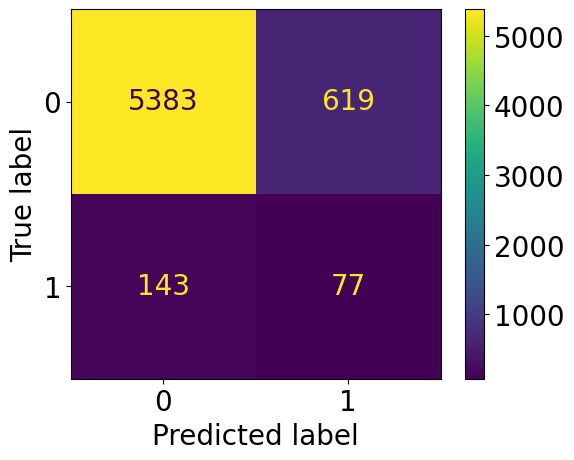

In [180]:
cmd = metrics.ConfusionMatrixDisplay.from_predictions(actual_test, fraud_pred)
tn, fp, fn, tp = cmd.confusion_matrix.ravel()

tnr = tn / (tn + fp)
tpr = tp / (tp + fn)

performance_df = pd.read_pickle(data_dir / "performance_anomalies.sav")

if_df = pd.DataFrame(
    [['Isolation Forest', tpr, tnr]], 
    columns=performance_df.columns,
)
if_df

performance_df = pd.concat([performance_df, if_df], ignore_index=True)
performance_df

In [ ]:
#=================================================-
#### Slide 30: Exercise 4  ####






In [181]:
#=================================================-
#### Slide 32: Isolation forest on time series data  ####

isolation_energy = IsolationForest(n_estimators=100, contamination = 0.01)

# model fitting
isolation_energy.fit(pd.DataFrame(pjm_energy['PJME_MW']))
pjm_energy['anomaly'] = isolation_energy.predict(pd.DataFrame(pjm_energy['PJME_MW']))




/Users/matskarz/opt/anaconda3/envs/py/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


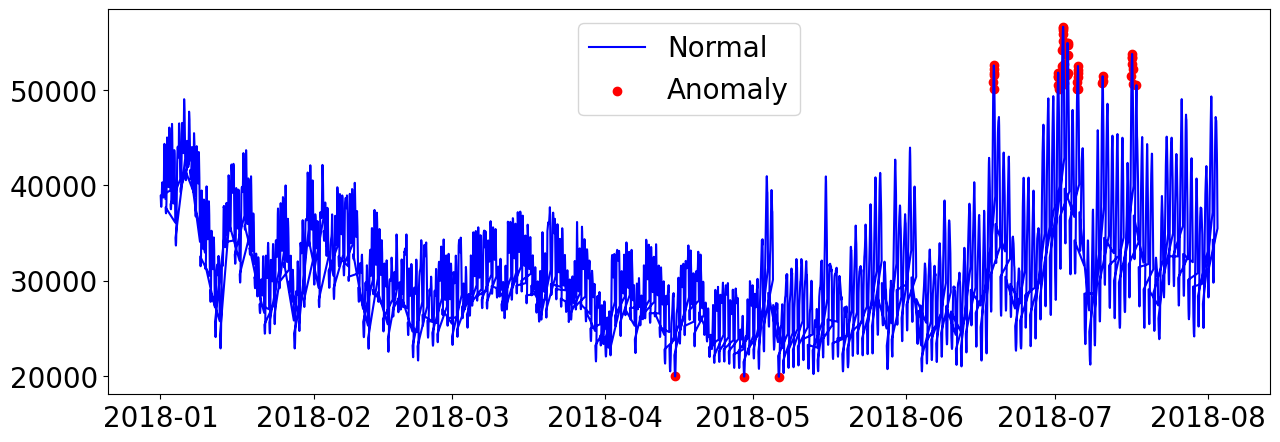

In [183]:
fig, ax = plt.subplots(figsize=(15,5))
a = pjm_energy.loc[pjm_energy['anomaly'] == -1, ['Datetime', 'PJME_MW']] #anomaly
ax.plot(pjm_energy['Datetime'], pjm_energy['PJME_MW'], color='blue', label = 'Normal')
ax.scatter(a['Datetime'],a['PJME_MW'], color='red', label = 'Anomaly')
plt.legend();

In [184]:
#=================================================-
#### Slide 34: Isolation forest - visualize anomalies  ####

# visualization
lower_threshold = pjm_energy['PJME_MW'].quantile(0.25)
upper_threshold = pjm_energy['PJME_MW'].quantile(0.75)
if_anomalies = pjm_energy[pjm_energy['anomaly'] == -1]

if_upper_anomalies = if_anomalies[if_anomalies['PJME_MW'] > upper_threshold]['PJME_MW']
if_lower_anomalies = if_anomalies[if_anomalies['PJME_MW'] < lower_threshold]['PJME_MW']




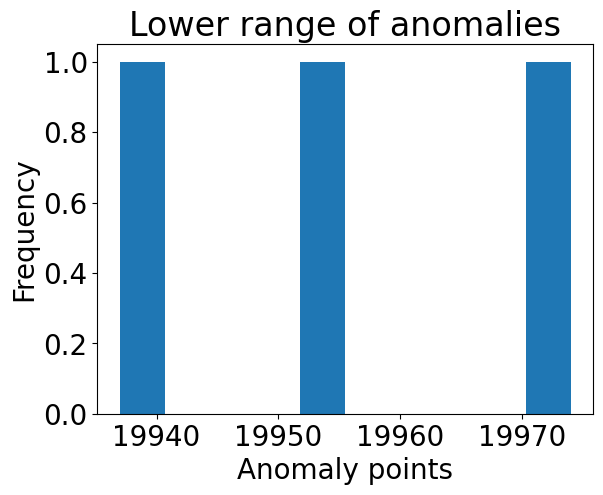

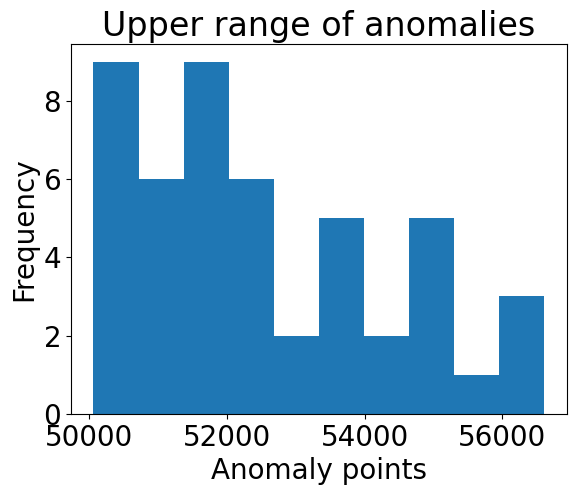

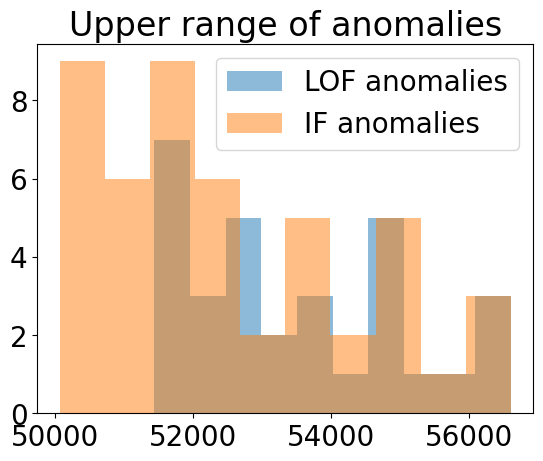

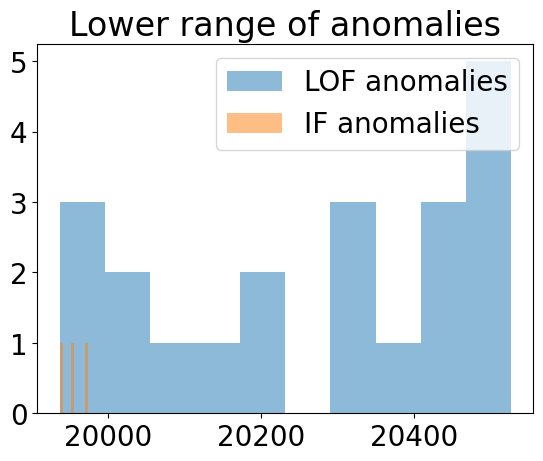

In [185]:
plt.hist(if_lower_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Lower range of anomalies")
plt.show()
plt.hist(if_upper_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Upper range of anomalies")
plt.show()
plt.hist(lof_upper_anomalies,alpha = 0.5,label='LOF anomalies')
plt.hist(if_upper_anomalies,alpha = 0.5,label='IF anomalies')
plt.title('Upper range of anomalies')
plt.legend(loc='upper right')
plt.show()
plt.hist(lof_lower_anomalies,alpha = 0.5,label='LOF anomalies')
plt.hist(if_lower_anomalies,alpha = 0.5,label='IF anomalies')
plt.title('Lower range of anomalies')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#=================================================-
#### Slide 37: Exercise 5  ####




#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################
